In [78]:
import sys, os
import torch
import pandas as pd
import glob
from tqdm import tqdm
from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

local_user_path = '/home/jgershon/git/cleo' # change to your own path
sys.path.append(local_user_path) 
from ensemble import Ensemble
from data_util import FragmentDataset

### load model and check prediction accuracy

In [79]:
# path to model checkpoint
base_path = '/home/jgershon/git/cleo/ckpt/initial_test/initial_test:2024-10-16-11-13-43'
ckpt_name = 'epoch=24-step=6200.ckpt'
ckpt = torch.load(os.path.join(base_path,ckpt_name))
config = OmegaConf.load(os.path.join(base_path,'config.yaml'))

# load model
model = Ensemble(config.model)
model.load_state_dict(ckpt['state_dict'])
model.eval()

# get dataset
dataset_path = f'{local_user_path}/data/four-site_clean_simplified_AA_data.csv'
data = pd.read_csv(dataset_path)
fragment_csv = f'{local_user_path}/{config.data.fragment_csv}'
dataset = FragmentDataset(data,
                config.data.input_col,
                config.data.label_col,
                config.data.name_col,
                fragment_csv,
                config.data.use_fragment_representation,)

/scratch/jgershon/25559901/ipykernel_1400173/1452325682.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(base_path,ckpt_name))


In [76]:
# run through the dataset
y_true = []
y_pred_mean = []
y_pred_std = []

for x, y in tqdm(dataset):
    
    y_pred = model(x[None])
    y_pred_mean.append(y_pred.mean().item())
    y_pred_std.append(y_pred.std().item())
    y_true.append(y.item())


100%|██████████| 159129/159129 [01:03<00:00, 2513.23it/s]


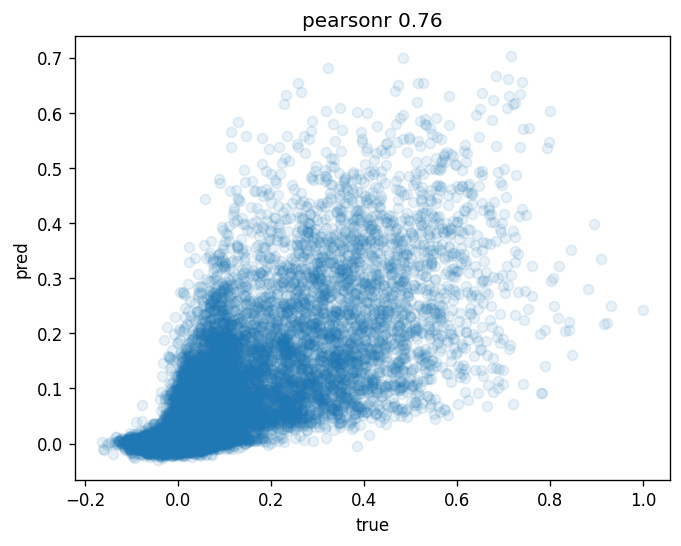

In [68]:
corr, _ = stats.pearsonr(y_true, y_pred_mean)

plt.figure(dpi=120)
plt.scatter(x=y_true,y=y_pred_mean,alpha=0.1)
plt.xlabel('true fitness')
plt.ylabel('pred fitness')
plt.title(f'pearsonr {corr:.2f}')
plt.show()

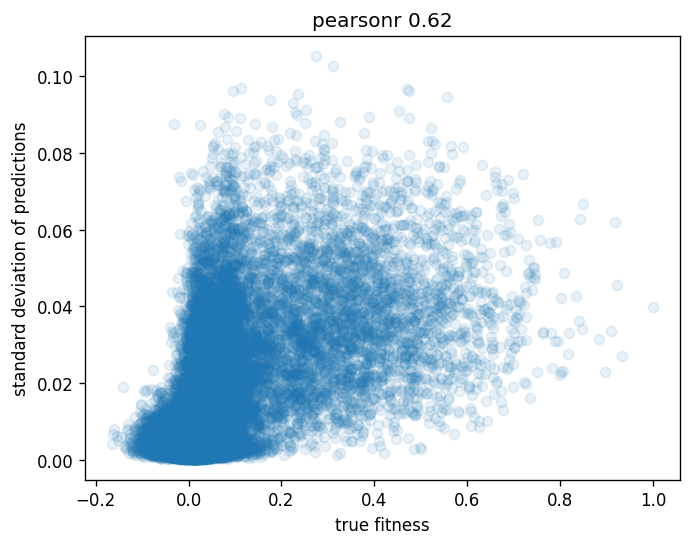

In [72]:
plt.figure(dpi=120)
corr, _ = stats.pearsonr(y_true, y_pred_std)

plt.scatter(x=y_true, y=y_pred_std, alpha=0.1)
plt.xlabel('true fitness')
plt.ylabel('standard deviation of predictions')
plt.title(f'pearsonr {corr:.2f}')
plt.show()

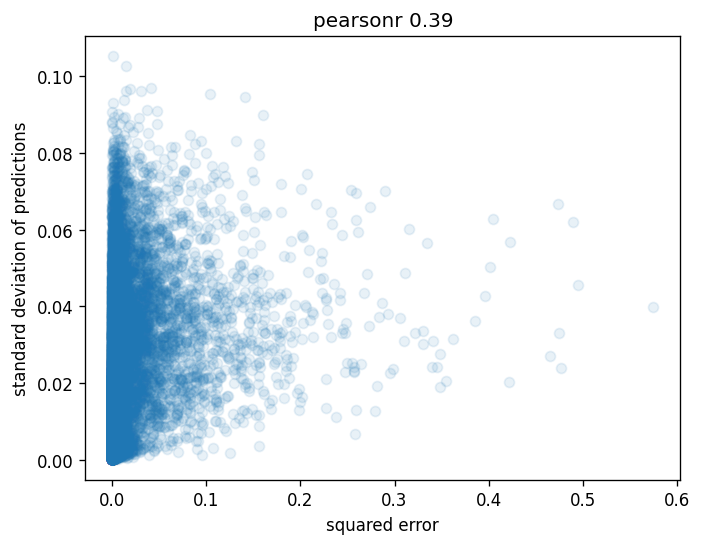

In [71]:
se = ((torch.tensor(y_true) - torch.tensor(y_pred_mean))**2).tolist()
corr, _ = stats.pearsonr(se, y_pred_std)
plt.figure(dpi=120)
plt.scatter(x=se, y=y_pred_std, alpha=0.1)
plt.xlabel('squared error')
plt.ylabel('standard deviation of predictions')
plt.title(f'pearsonr {corr:.2f}')
plt.show()